# Pangenome dataset export

## Setup

In [1]:
## Notebook config

import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

# Notebook imports
import os
import ast

from graphdatascience import GraphDataScience
import pandas as pd

/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_DIR = './dataset/'
PROJECTION_NAME_PREFIX = 'dataset_projection_'

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

RANDOM_SEED = 42

## Create GDS projection

In [24]:
# GDS utils

graph_config = {
    'node_spec': {
        'Fasta': {},
        'Hit': {},
        'HitFamily': {},
        'HitRegion': {},
    },
    'relationship_spec' : {
        'hasHit': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
        'hasRegion': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
        'hasAffiliate': {'orientation': 'UNDIRECTED', 'properties': {'coverage': {'defaultValue': 1}}},
        'hasMember': {'orientation': 'UNDIRECTED', 'properties': {'probab': {'defaultValue': 1}}},
        'hasDownstream': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
    },
}

def get_pg_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_kg_connection():
    return GraphDataScience(
        os.environ.get('NEO4J_KG_URI'),
        auth=(
            os.environ.get('NEO4J_KG_USER'), 
            os.environ.get('NEO4J_KG_PASSWORD'),
        )
    )

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)

def get_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    projection = gds.graph.project(
        graph_name=projection_name,
        node_spec=list(graph_config['node_spec'].keys()),
        relationship_spec=graph_config['relationship_spec'],
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))

# At least one common node property is needed to use the gds node export function
def add_degree_property(gds, projection_name):
    df_degree = gds.degree.mutate(
        G=gds.graph.get(projection_name),
        mutateProperty='degree',
        nodeLabels=["*"],
        relationshipTypes=["*"],
    )

def add_fastrp_embedding(gds, projection_name):
    df_fastrp = gds.fastRP.mutate(
        G=gds.graph.get(projection_name),
        mutateProperty='fastrp',
        randomSeed=42,
        # relationshipWeightProperty='weight',
        nodeLabels=[
            'Fasta',
            'Hit',
            'HitFamily',
            'HitRegion',
        ],
        relationshipTypes=[
            "hasHit",
            "hasRegion",
            "hasAffiliate",
            "hasMember",
            "hasDownstream",
        ],
        embeddingDimension=128,
        normalizationStrength=-0.5,
        # nodeSelfInfluence=2,
    )

In [51]:
# Create GDS projection

version = 1
projection_name = get_projection_name(version)
gds = get_pg_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name)
add_degree_property(gds, projection_name)
print(projection)

GraphCreateResult(graph=Graph({'graphName': 'dataset_projection_1', 'nodeCount': 148782, 'relationshipCount': 787238, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'hasHit': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasHit'}, 'hasMember': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'probab': {'aggregation': 'DEFAULT', 'property': 'probab', 'defaultValue': 1}}, 'type': 'hasMember'}, 'hasRegion': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasRegion'}, 'hasDownstream': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'h

## Export Pangenome Datasets

In [7]:
NUMBER_OF_NODES = 148782
NUMBER_OF_EDGES = 393619

In [17]:
# Export nodes from projection to df

def export_nodes_from_projection(property, projection_name=get_projection_name()):
    nodes = gds.graph.nodeProperties.stream(
        get_projection(gds, projection_name),
        node_properties=[property],
        separate_property_columns=True,
        db_node_properties=[
            'accession',
            'name',
            'annotation',
            'subtype',
            'std_length',
            'source',
            'taxonomy',
            'circular',
            'begin',
            'end',
            'hit_begin'
            'hit_end',
            'frame',
            'strand',
        ],
        listNodeLabels=True,
    )
    nodes['nodeLabels'] = nodes['nodeLabels'].apply(lambda x: x[0])
    return nodes


nodes = export_nodes_from_projection('degree')

assert nodes.shape[0] == NUMBER_OF_NODES

In [19]:
# Enrich nodes df and save to csv

## Enrich Genomes with taxonomic labels from ICTV string
def get_taxonomy_by_idx(tax_str, idx):
    try:
        value = tax_str.split(';')[idx].strip()
        if value == '' or value == 'Null':
            return None
        return value
    except:
        return None

def enrich_data_with_tax_labels(df):
    rank_index = {
        'clade': 0,
        'kingdom': 2,
        'phylum': 4,
        'class': 6,
        'order': 8,
        'family': 10,
        'genus': 12,
        'species': 14,
    }
    for rank in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
        df[rank] = None
        df.loc[df['nodeLabels'] == 'Fasta', rank] = df.loc[
            df['nodeLabels'] == 'Fasta', 'taxonomy'].apply(get_taxonomy_by_idx, args=[rank_index[rank]])
    return df

## nodeId is not stable in neo4j, instead add a reference to a stable node attribute
def set_node_app_id(df):
    config = {
        'Fasta': 'accession',
        'Hit': 'name',
        'HitFamily': 'accession',
        'HitRegion': 'name',
    }
    df['appId'] = None
    for node_label, id_column in config.items():
        df.loc[df['nodeLabels'] == node_label, 'appId'] = df.loc[
            df['nodeLabels'] == node_label, id_column]
    
    return df

## Add isSegmented to Fasta nodes
def set_segmented(df):
    df['isSegmented'] = None
    df.loc[df['nodeLabels'] == 'Fasta', 'isSegmented'] = df.loc[
        df['nodeLabels'] == 'Fasta', 'name'].apply(lambda x: '|Seg' in x)
    

enrich_data_with_tax_labels(nodes)
set_node_app_id(nodes)
set_segmented(nodes)

assert nodes.shape[0] == NUMBER_OF_NODES
nodes.to_csv(DATASET_DIR + 'pangenome_nodes.csv', index=False)

In [21]:
# Export dataset edges from projection

edges = pd.DataFrame()
for unique_property in ['score', 'coverage', 'probab']:
    edges = pd.concat([
        edges,
        gds.graph.relationshipProperties.stream(
            get_projection(gds, get_projection_name(version)),
            relationship_properties=[unique_property],
        )
    ])

# reset index
edges.reset_index(drop=True, inplace=True)

assert edges.shape[0] == NUMBER_OF_EDGES

In [23]:
# Enrich edges and save to csv

node_map_cache = {}
def set_edge_app_ids(df):
    df_copy = df.copy()
    df_copy['sourceAppId'] = None
    df_copy['targetAppId'] = None
    for i, row in df.iterrows():
        if row['sourceNodeId'] not in node_map_cache:
            node_map_cache[row['sourceNodeId']] = nodes.loc[nodes['nodeId'] == row['sourceNodeId'], 'appId'].values[0]
        if row['targetNodeId'] not in node_map_cache:
            node_map_cache[row['targetNodeId']] = nodes.loc[nodes['nodeId'] == row['targetNodeId'], 'appId'].values[0]

        df_copy.at[i, 'sourceAppId'] = node_map_cache[row['sourceNodeId']]
        df_copy.at[i, 'targetAppId'] = node_map_cache[row['targetNodeId']]

        # if row['sourceNodeId'] == 44762:
        #     # print(row['sourceNodeId'], node_map_cache[row['sourceNodeId']])
        #     print(df_copy.at[i, 'sourceAppId'])

        # if i > 100:
        #     # print()
        #     print(
        #         df_copy.loc[df_copy['sourceNodeId'] == 44762, 'sourceAppId'],
        #     )
        #     break

    return df_copy

def set_edge_weights(df):
    config = {
        'hasHit': 'score',
        'hasRegion': 'score',
        'hasAffiliate': 'coverage',
        'hasMember': 'probab',
        'hasDownstream': 'score',
    }
    df['weight'] = None
    for relationship_type, weight_column in config.items():
        condition = (df['relationshipType'] == relationship_type) & (df['relationshipProperty'] == weight_column)
        df.loc[condition, 'weight'] = df.loc[condition, 'propertyValue']
    return df

edges = set_edge_weights(edges)
edges = set_edge_app_ids(edges)

assert edges.shape[0] == NUMBER_OF_EDGES
edges.to_csv(DATASET_DIR + 'pangenome_edges.csv', index=False)

In [20]:
# drop projection from Neo4j DB memory
gds.graph.drop(get_projection_name())

graphName                                             dataset_projection_1
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                           148782
relationshipCount                                                   787238
configuration            {'relationshipProjection': {'hasHit': {'aggreg...
density                                                           0.000036
creationTime                           2024-04-30T23:10:29.592752103+00:00
modificationTime                       2024-04-30T23:10:31.124691843+00:00
schema                   {'graphProperties': {}, 'nodes': {'HitRegion':...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'HitRegion':...
Name: 0, dtype: object

## Export NCBI Taxonomy dataset

In [14]:
# Create taxonomy projection from existing serratus/SRA knowledge graph

taxonomy_projection_name = 'taxonomy_projection'

def get_taxon_nodes(gds):
    if os.path.exists(DATASET_DIR + 'taxon_nodes.csv'):
        return pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    query = '''
            MATCH (n:Taxon)
            RETURN
                id(n) as nodeId,
                n.taxId as appId,
                n.taxId as taxId,
                labels(n) as nodeLabels,
                n.rank as rank,
                n.taxKingdom as taxKingdom,
                n.taxPhylum as taxPhylum,
                n.taxOrder as taxOrder,
                apoc.node.degree(n, "HAS_PARENT") as hasParentDegree,
                apoc.node.degree(n, "HAS_PARENT>") as hasParentOutDegree,
                apoc.node.degree(n, "<HAS_PARENT") as hasParentInDegree
            '''
    df = gds.run_cypher(query)
    df['nodeLabels'] = df['nodeLabels'].apply(lambda x: ast.literal_eval(x)[0])
    df.to_csv(DATASET_DIR + 'taxon_nodes.csv', index=False)
    return df


def get_taxon_has_parent_edges(gds):
    if os.path.exists(DATASET_DIR + 'taxon_has_parent_edges.csv'):
        return pd.read_csv(DATASET_DIR + 'taxon_has_parent_edges.csv')
    query = '''
            MATCH (s:Taxon)-[r:HAS_PARENT]->(t:Taxon)
            RETURN
                id(s) as sourceNodeId,
                s.taxId as sourceAppId,
                id(t) as targetNodeId,
                t.taxId as targetAppId,
                type(r) as relationshipType,
                1 as weight
            '''
    df = gds.run_cypher(query)
    df.to_csv(DATASET_DIR + 'taxon_has_parent_edges.csv', index=False)
    return df

kg_client = get_kg_connection()
taxon_nodes = get_taxon_nodes(kg_client)
taxon_has_parent_edges = get_taxon_has_parent_edges(kg_client)

In [21]:
# Export node embeddings for testing

def get_taxonomy_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    nodes = get_taxon_nodes(gds)
    nodes = nodes.loc[
        nodes['taxKingdom'] == 'Viruses'
    ]
    nodes['labels'] = nodes['nodeLabels']
    nodes = nodes[[
        'nodeId',
        'labels',
    ]]

    relationships = get_taxon_has_parent_edges(gds)
    relationships = relationships[[
        'sourceNodeId',
        'targetNodeId',
        'relationshipType',
        'weight'
    ]]
    undirected_relationship_types = relationships['relationshipType'].unique().tolist()
    projection = gds.graph.construct(
        graph_name=projection_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=undirected_relationship_types,
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))

def add_fastrp_embedding(gds, projection_name):
    df_fastrp = gds.fastRP.mutate(
        G=gds.graph.get(projection_name),
        mutateProperty='fastrp',
        randomSeed=42,
        nodeLabels=[
            'Taxon',
        ],
        relationshipTypes=[
            "HAS_PARENT",
        ],
        embeddingDimension=128,
        normalizationStrength=-0.5,
    )

def export_nodes_from_projection(gds, projection_name, property):
    nodes = gds.graph.nodeProperties.stream(
        get_projection(gds, projection_name),
        node_properties=[property],
        separate_property_columns=True,
        db_node_properties=[
            'taxId',
            'rank',
            'taxKingdom',
            'taxPhylum',
            'taxOrder',
        ],
        listNodeLabels=True,
    )
    nodes['nodeLabels'] = nodes['nodeLabels'].apply(lambda x: x[0])
    return nodes


def set_node_app_id(df):
    config = {
        'Taxon': 'taxId',
    }
    df['appId'] = None
    for node_label, id_column in config.items():
        df.loc[df['nodeLabels'] == node_label, 'appId'] = df.loc[
            df['nodeLabels'] == node_label, id_column]
    return df


kg_client = get_kg_connection()
delete_projection(gds, projection_name)
projection = get_taxonomy_projection(kg_client, taxonomy_projection_name)
add_fastrp_embedding(kg_client, taxonomy_projection_name)

nodes = export_nodes_from_projection(kg_client, taxonomy_projection_name, 'fastrp')
nodes = set_node_app_id(nodes)
nodes.to_csv(DATASET_DIR + 'taxon_nodes_emb.csv', index=False)

In [37]:
# Create Fasta to Taxon relationships

def get_fasta_has_tax_order_edges(gds):
    if os.path.exists(DATASET_DIR + 'fasta_has_tax_order_edges.csv'):
        return pd.read_csv(DATASET_DIR + 'fasta_has_tax_order_edges.csv')

    taxon_nodes = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    order_nodes = taxon_nodes.loc[taxon_nodes['rank'] == 'order']

    pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    fasta_nodes = pangenome_nodes.loc[pangenome_nodes['nodeLabels'] == 'Fasta']
    
    merged = pd.merge(
        fasta_nodes,
        order_nodes,
        how='left',
        left_on='order',
        right_on='taxOrder',
        suffixes=('', '_taxon')
    )
    
    print(merged['taxOrder'].isna().sum())

    rows = []
    for i, fasta in merged.iterrows():
        if pd.isna(fasta['taxOrder']):
            continue
        rows.append({
            'sourceNodeId': fasta['nodeId'],
            'targetNodeId': int(fasta['nodeId_taxon']),
            'sourceAppId': fasta['appId'],
            'targetAppId': int(fasta['appId_taxon']),
            'relationshipType': 'HAS_TAX_ORDER',
            'weight': 1,
        })
    df = pd.DataFrame(rows)
    df.to_csv(DATASET_DIR + 'fasta_has_tax_order_edges.csv', index=False)
    return df

fasta_has_tax_order_edges = get_fasta_has_tax_order_edges(kg_client)

120


In [8]:
# Create Fasta to Taxon phylum relationships

def get_fasta_has_tax_phylum_edges(gds):
    if os.path.exists(DATASET_DIR + 'get_fasta_has_tax_phylum_edges.csv'):
        return pd.read_csv(DATASET_DIR + 'get_fasta_has_tax_phylum_edges.csv')

    taxon_nodes = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    order_nodes = taxon_nodes.loc[taxon_nodes['rank'] == 'phylum']

    pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    fasta_nodes = pangenome_nodes.loc[pangenome_nodes['nodeLabels'] == 'Fasta']
    
    merged = pd.merge(
        fasta_nodes,
        order_nodes,
        how='left',
        left_on='phylum',
        right_on='taxPhylum',
        suffixes=('', '_taxon')
    )
    
    print(merged['taxPhylum'].isna().sum())

    rows = []
    for i, fasta in merged.iterrows():
        if pd.isna(fasta['taxPhylum']):
            continue
        rows.append({
            'sourceNodeId': fasta['nodeId'],
            'targetNodeId': int(fasta['nodeId_taxon']),
            'sourceAppId': fasta['appId'],
            'targetAppId': int(fasta['appId_taxon']),
            'relationshipType': 'HAS_TAX_PHYLUM',
            'weight': 1,
        })
    df = pd.DataFrame(rows)
    df.to_csv(DATASET_DIR + 'fasta_has_tax_phylum_edges.csv', index=False)
    return df

fasta_has_tax_phylum_edges = get_fasta_has_tax_phylum_edges(None)

107


## Resampled dataset

In [9]:
def get_representative_has_affiliates(gds):
    if os.path.exists(DATASET_DIR + 'pangenome_representatives.csv'):
        return pd.read_csv(DATASET_DIR + 'pangenome_representatives.csv')
    query = '''
        MATCH (a:HitRegion)-[r:hasAffiliate]->(b:Hit)
        WHERE r.representation = True
        RETURN 
            id(a) as sourceNodeId,
            a.name as sourceAppId,
            id(b) as targetNodeId,
            b.name as targetAppId,
            r.coverage as weight,
            "hasAffiliate" as relationshipType,
            1.0 as relationshipProperty,
            1.0 as propertyValue
    '''
    df = gds.run_cypher(query)
    df.to_csv(DATASET_DIR + 'pangenome_representatives.csv', index=False)
    return df

pg_client = get_pg_client()
representative_has_affiliates = get_representative_has_affiliates(pg_client)

In [25]:
def get_fasta_domain_counts(gds):
    if os.path.exists(DATASET_DIR + 'fasta_domain_counts.csv'):
        return pd.read_csv(DATASET_DIR + 'fasta_domain_counts.csv')
    query = '''
            MATCH (f:Fasta)-[:hasHit]->(h:Hit)<-[:hasMember]->(r:HitFamily)
            RETURN
                f.accession as fastaAccession,
                count(DISTINCT r) as domainCount
            '''
    df = gds.run_cypher(query)
    df.to_csv(DATASET_DIR + 'fasta_domain_counts.csv', index=False)
    return df

pg_client = get_pg_client()
fasta_domain_counts = get_fasta_domain_counts(pg_client)

In [75]:
def get_domain_fasta_counts(gds):
    if os.path.exists(DATASET_DIR + 'domain_fasta_counts.csv'):
        return pd.read_csv(DATASET_DIR + 'domain_fasta_counts.csv')
    query = '''
            MATCH (f:Fasta)-[:hasHit]->(h:Hit)<-[:hasMember]->(r:HitFamily)
            RETURN
                r.accession as domainAccession,
                count(DISTINCT f) as fastaCount
            '''
    df = gds.run_cypher(query)
    df.to_csv(DATASET_DIR + 'domain_fasta_counts.csv', index=False)
    return df

pg_client = get_pg_client()
domain_fasta_counts = get_domain_fasta_counts(pg_client)

In [6]:
pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
fasta_nodes = pangenome_nodes.loc[
    (pangenome_nodes['nodeLabels'] == 'Fasta') 
]
fasta_nodes = pd.merge(fasta_nodes, fasta_domain_counts, left_on='accession', right_on='fastaAccession')
fasta_nodes = fasta_nodes.loc[
    (fasta_nodes['isSegmented'] == False)
] 
fasta_nodes = fasta_nodes[
    [
        'nodeId',
        'appId',
        'accession',
        'name',
        'domainCount',
        'species',
        'genus',
        'family',
        'order',
        'class',
        'phylum',
        'isSegmented'
    ]
]

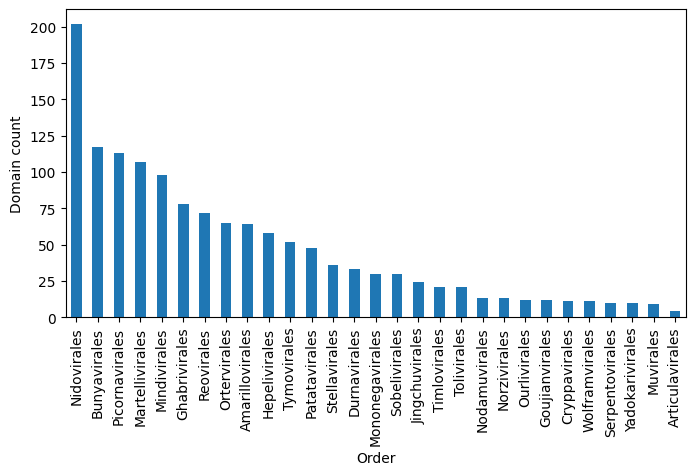

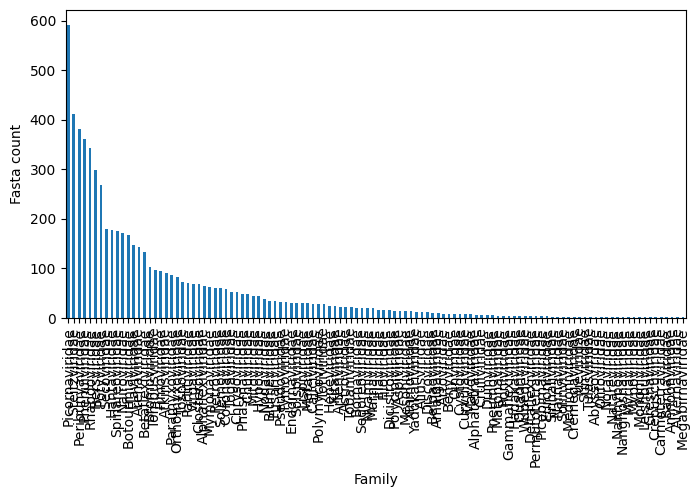

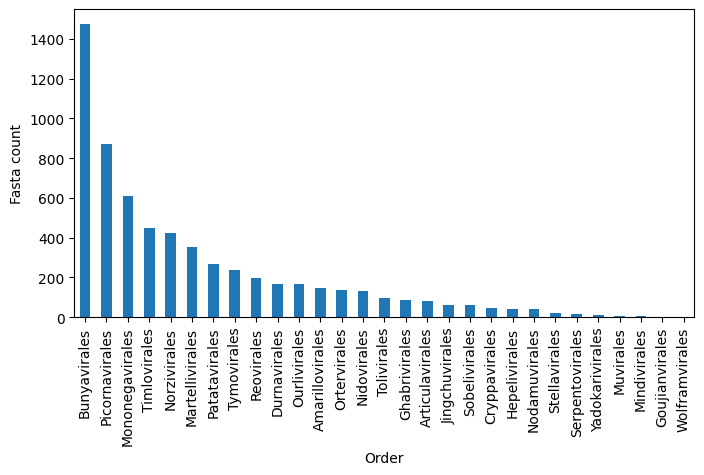

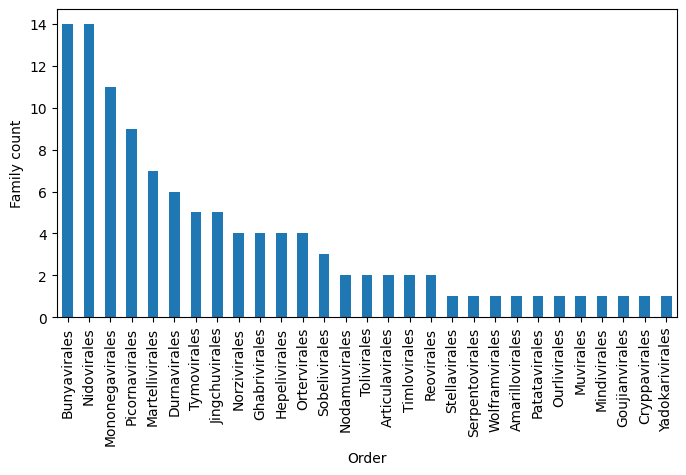

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_data = fasta_nodes.groupby('order')['domainCount'].max().sort_values(ascending=False)
plot_data.plot(kind='bar', ax=ax)
ax.set_ylabel('Domain count')
ax.set_xlabel('Order')
fig.set_size_inches(8, 4)
plt.show()

# create plot of number of fastas per family

# fig, ax = plt.subplots()
# plot_data = fasta_nodes.groupby('family').size().sort_values(ascending=False)
# plot_data.plot(kind='bar', ax=ax)
# ax.set_ylabel('Fasta count')
# ax.set_xlabel('Family')
# fig.set_size_inches(8, 4)
# plt.show()

# fig, ax = plt.subplots()
# plot_data = fasta_nodes.groupby('order').size().sort_values(ascending=False)
# plot_data.plot(kind='bar', ax=ax)
# ax.set_ylabel('Fasta count')
# ax.set_xlabel('Order')
# fig.set_size_inches(8, 4)
# plt.show()

# count number of families per order

fig, ax = plt.subplots()
plot_data = fasta_nodes.groupby('order')['family'].nunique().sort_values(ascending=False)
plot_data.plot(kind='bar', ax=ax)
ax.set_ylabel('Family count')
ax.set_xlabel('Order')
fig.set_size_inches(8, 4)
plt.show()



In [31]:
# create list of fastas with one per family using the one with the most domains
print(fasta_nodes['family'].nunique())

resampled_fasta_nodes = fasta_nodes.sort_values('domainCount', ascending=False)
resampled_fasta_nodes = fasta_nodes.drop_duplicates('family')

print(resampled_fasta_nodes['family'].nunique())

resampled_fasta_nodes.to_csv(DATASET_DIR + 'fasta_resampled_family.csv', index=False)

114
114


In [122]:
# Alt approach: resample using rwr with HitFamily as seed nodes

pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
hit_family_nodes = pangenome_nodes.loc[
    pangenome_nodes['nodeLabels'] == 'HitFamily'
]
start_nodes = hit_family_nodes['nodeId'].tolist()

sampling_ratio = 0.25

if gds.graph.exists('test_resampling')['exists']:
    gds.graph.drop('test_resampling')

G_dataset, _  = gds.graph.sample.cnarw(
    graph_name='test_resampling',
    from_G=gds.graph.get(get_projection_name(version)),
    concurrency=1 if start_nodes is None else 4,
    randomSeed=RANDOM_SEED if start_nodes is None else None,
    samplingRatio=sampling_ratio,
    nodeLabelStratification=True,
    # relationshipWeightProperty='weight',
    nodeLabels=[
        'Fasta',
        'Hit',
        'HitFamily',
        # 'HitRegion'
    ],
    relationshipTypes=[
        'hasHit',
        # 'hasRegion',
        # 'hasAffiliate',
        'hasMember',
        # 'hasDownstream',
    ],
    startNodes=start_nodes,
)

In [123]:
projection = gds.graph.get(get_projection_name(version))
print(projection)
print(G_dataset)
nodes = export_nodes_from_projection('degree', 'test_resampling')


Graph(name=dataset_projection_1, node_count=148782, relationship_count=787238)
Graph(name=test_resampling, node_count=31489, relationship_count=77036)


/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: hit_beginhit_end)
  warnings.warn(warning)


In [129]:
fasta_nodes_resampled = nodes.loc[
    nodes['nodeLabels'] == 'Fasta'
]

print(fasta_nodes_resampled.shape[0])

fasta_nodes_resampled.to_csv(DATASET_DIR + 'fasta_resampled_rwr.csv', index=False)

1676


(6702, 24)
(1676, 2)
(1691, 25)
(1691, 27)
Index(['nodeId_x', 'accession', 'nodeId_y', 'degree', 'nodeLabels', 'name',
       'annotation', 'subtype', 'std_length', 'source', 'taxonomy', 'circular',
       'begin', 'end', 'hit_beginhit_end', 'frame', 'strand', 'species',
       'genus', 'family', 'order', 'class', 'phylum', 'appId', 'isSegmented',
       'fastaAccession', 'domainCount'],
      dtype='object')


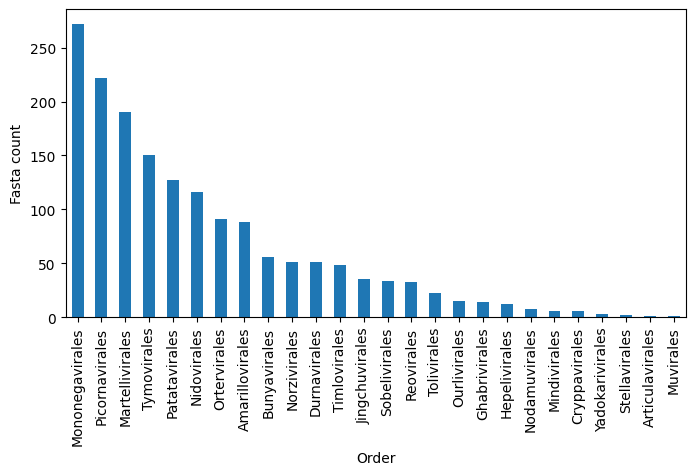

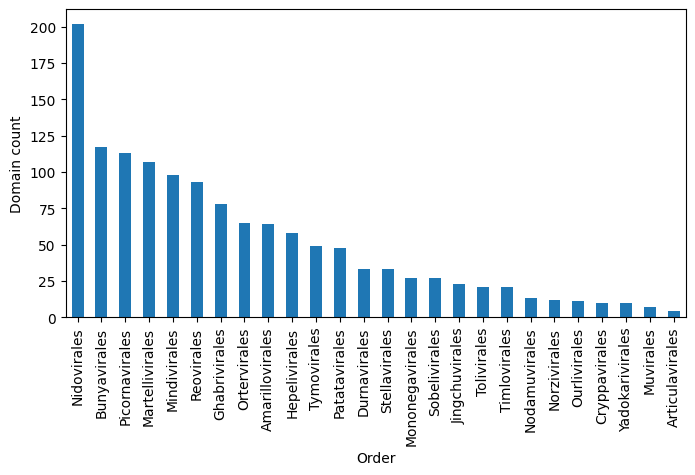

In [125]:
pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
fasta_nodes_all = pangenome_nodes.loc[
    pangenome_nodes['nodeLabels'] == 'Fasta'
]
print(fasta_nodes_all.shape)

fasta_nodes_resampled = nodes.loc[
    nodes['nodeLabels'] == 'Fasta'
]
fasta_nodes_resampled = fasta_nodes_resampled[[
    'nodeId',
    'accession',
]]
print(fasta_nodes_resampled.shape)

fasta_nodes_resampled = pd.merge(fasta_nodes_resampled, fasta_nodes_all, on='accession', how='left')
print(fasta_nodes_resampled.shape)


fasta_nodes_resampled = pd.merge(
    fasta_nodes_resampled, fasta_domain_counts, left_on='accession', right_on='fastaAccession')

print(fasta_nodes_resampled.shape)

fasta_nodes_resampled = fasta_nodes_resampled[
    [
        'appId',
        'species',
        'genus',
        'family',
        'order',
        'class',
        'phylum',
        'domainCount',
        'isSegmented'
    ]
]

fig, ax = plt.subplots()
plot_data = fasta_nodes_resampled.groupby('order').size().sort_values(ascending=False)
plot_data.plot(kind='bar', ax=ax)
ax.set_ylabel('Fasta count')
ax.set_xlabel('Order')
fig.set_size_inches(8, 4)
plt.show()


fig, ax = plt.subplots()
plot_data = fasta_nodes_resampled.groupby('order')['domainCount'].max().sort_values(ascending=False)
plot_data.plot(kind='bar', ax=ax)
ax.set_ylabel('Domain count')
ax.set_xlabel('Order')
fig.set_size_inches(8, 4)
plt.show()

In [31]:
gds.graph.drop('test_resampling')


graphName                                                  test_resampling
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            14879
relationshipCount                                                     7019
configuration            {'nodeLabelStratification': True, 'relationshi...
density                                                           0.000032
creationTime                           2024-05-26T19:32:39.747094759+00:00
modificationTime                       2024-05-26T19:32:39.746366804+00:00
schema                   {'graphProperties': {}, 'nodes': {'HitRegion':...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'HitRegion':...
Name: 0, dtype: object

In [63]:
pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
fasta_nodes_all = pangenome_nodes.loc[
    pangenome_nodes['nodeLabels'] == 'Fasta'
]

fasta_domain_counts = get_fasta_domain_counts(None)
max_domain_count = fasta_domain_counts['domainCount'].max()

fasta_nodes_all = pd.merge(
    fasta_nodes_all, fasta_domain_counts, left_on='accession', right_on='fastaAccession')

fasta_nodes_all = fasta_nodes_all.drop(columns=['fastaAccession'])
print(fasta_nodes_all.shape)
print(fasta_nodes_all.columns)
print(fasta_nodes_all['order'].nunique())
print(fasta_nodes_all['order'].value_counts().head(3))
print(fasta_nodes_all['order'].value_counts().tail(3))
# get average count of orders as int
avg_n = int(fasta_nodes_all.groupby('order').size().mean())
std = int(fasta_nodes_all.groupby('order').size().std())
median = int(fasta_nodes_all.groupby('order').size().median())
print(avg_n)
print(std)
print(median)


(6702, 25)
Index(['nodeId', 'degree', 'nodeLabels', 'accession', 'name', 'annotation',
       'subtype', 'std_length', 'source', 'taxonomy', 'circular', 'begin',
       'end', 'hit_beginhit_end', 'frame', 'strand', 'species', 'genus',
       'family', 'order', 'class', 'phylum', 'appId', 'isSegmented',
       'domainCount'],
      dtype='object')
29
order
Bunyavirales       1476
Picornavirales      872
Mononegavirales     613
Name: count, dtype: int64
order
Mindivirales      8
Wolframvirales    2
Goujianvirales    2
Name: count, dtype: int64
226
320
105


In [90]:
# Alt approach: sample fraction of group, weighted by domain count

# fasta_nodes_all.groupby('order').size().sort_values(ascending=True).head(10)
resampled_fasta_nodes = fasta_nodes_all.groupby('order').sample(
    # frac=0.5,
    n=avg_n,
    weights=[ x / (max_domain_count) for x in fasta_nodes_all['domainCount']],
    random_state=RANDOM_SEED,
    replace=True,
)
# drop duplicates
resampled_fasta_nodes = resampled_fasta_nodes.drop_duplicates('appId')

# remove orders with less than std samples
resampled_fasta_nodes = resampled_fasta_nodes.groupby('order').filter(lambda x: len(x) > median)
resampled_fasta_nodes = resampled_fasta_nodes.groupby('order').filter(lambda x: len(x) < (avg_n + std))
print(resampled_fasta_nodes.shape)
print(resampled_fasta_nodes['order'].nunique())
print(resampled_fasta_nodes['order'].value_counts().head(3))
print(resampled_fasta_nodes['order'].value_counts().tail(3))


resampled_fasta_nodes.to_csv(DATASET_DIR + 'fasta_resampled_fixed.csv', index=False)


(2190, 25)
14
order
Bunyavirales      208
Picornavirales    204
Timlovirales      184
Name: count, dtype: int64
order
Nidovirales        114
Ortervirales       110
Amarillovirales    107
Name: count, dtype: int64


In [89]:
# low perf orders have lower mean domain count
high_perf_orders = ['Picornavirales', 'Tymovirales', 'Patatavirales']
low_perf_orders = ['Bunyavirales', 'Reovirales', 'Durnavirales']
for order in high_perf_orders:
    print(order)
    print(resampled_fasta_nodes.loc[resampled_fasta_nodes['order'] == order, 'domainCount'].describe())
    # domain_fasta_counts
    print(domain_fasta_counts.loc[domain_fasta_counts['domainAccession'] == order, 'fastaCount'])

Bunyavirales
count    206.000000
mean       7.300971
std       11.966893
min        1.000000
25%        5.000000
50%        6.000000
75%        8.000000
max      117.000000
Name: domainCount, dtype: float64
Reovirales
count    117.000000
mean      10.153846
std       16.743303
min        1.000000
25%        1.000000
50%        7.000000
75%       10.000000
max       93.000000
Name: domainCount, dtype: float64
Durnavirales
count    110.000000
mean      18.481818
std        9.070298
min        6.000000
25%        9.000000
50%       20.500000
75%       28.000000
max       33.000000
Name: domainCount, dtype: float64


In [94]:
print(domain_fasta_counts['domainAccession'].nunique())

print(domain_fasta_counts['fastaCount'].max())
print(domain_fasta_counts['fastaCount'].min())
print(domain_fasta_counts['fastaCount'].mean())
print(domain_fasta_counts['fastaCount'].median())
print(domain_fasta_counts['fastaCount'].std())

# print top 10 domains
print(domain_fasta_counts.sort_values('fastaCount', ascending=False).head(10))

# filter out domains with > 3092
resampled_domains = domain_fasta_counts.loc[
    domain_fasta_counts['fastaCount'] < 3092
]
print(resampled_domains.shape)
print(resampled_domains['domainAccession'].nunique())
print(resampled_domains['fastaCount'].max())
print(resampled_domains['fastaCount'].min())
print(resampled_domains['fastaCount'].mean())
print(resampled_domains['fastaCount'].median())
print(resampled_domains['fastaCount'].std())

# save resampled domains
resampled_domains.to_csv(DATASET_DIR + 'resampled_domains.csv', index=False)



979
3922
1
115.13993871297242
15.0
370.9108721514642
   domainAccession  fastaCount
7          PF05919        3922
8          PF05788        3903
4          PF00998        3690
3          PF00680        3622
5          PF00978        3488
1          PF02123        3439
2          PF00972        3294
6          PF03431        3092
18         PF00946        1820
90         PF04197        1625
(971, 2)
971
1820
1
86.78887744593203
14.0
199.11898147433797


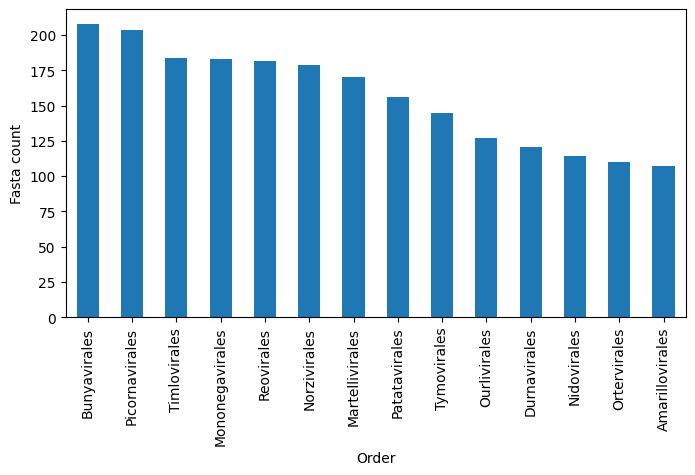

In [96]:

fig, ax = plt.subplots()
plot_data = resampled_fasta_nodes.groupby('order').size().sort_values(ascending=False)
plot_data.plot(kind='bar', ax=ax)
ax.set_ylabel('Fasta count')
ax.set_xlabel('Order')
fig.set_size_inches(8, 4)
plt.show()
